In [0]:
!ls

## Setting up Colab

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive
!pip3 install torch torchvision
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
!pip install tensorboardX
!npm install -g localtunnel

In [0]:
!pip install --no-cache-dir -I pillow

In [0]:
import os
os.chdir("drive/Collab/GANs")
!ls

In [0]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import os
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.autograd.variable import Variable


%matplotlib inline
%pylab inline

In [0]:
#Tensorboard setup

LOG_DIR = './logs'
from tensorboardX import SummaryWriter
summary_writer = SummaryWriter(LOG_DIR)


get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)



In [0]:
!rm url.txt

In [0]:

# Tunnel port 6006 (TensorBoard assumed running)
get_ipython().system_raw('lt --port 6006 >> url.txt 2>&1 &')

# Get url
!cat url.txt

### Helper Fxns

In [0]:
def data(dataset):
  dataset = eval('torchvision.datasets.'+dataset)
  transform = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((.5,.5,.5),(.5,.5,.5))
                                 ])
  trainset = dataset(root='../data', train=True,download=True, transform=transform)
  print(trainset.train_data.shape)
  imshow(trainset.train_data[0])
  return trainset


In [0]:
def images_to_vectors(images):
  return images.view(images.size(0), 28*28)

def vectors_to_images(vectors):
  return vectors.view(vectors.size(0), 1, 28, 28)

In [0]:
def noise(size):
  n = Variable(torch.randn(size, 100))
  
  if torch.cuda.is_available() : return n.cuda()
  print('not_cuda')
  return n

In [0]:
import torchvision.utils as utils

def load(images, epoch, batch):
  grid = utils.make_grid(images, normalize=True, scale_each=True)
  fig = figure(figsize=(16,16))
  imshow(np.moveaxis(grid.numpy(), 0, -1))
  axis('off')
  fig.savefig('images/epoch_{}_batch_{}.png'.format(epoch, batch))
  
  return grid

def log(g_error, d_error, steps):
  summary_writer.add_scalar('generator_error', float(g_error), steps)
  summary_writer.add_scalar('discriminator_error', float(d_error), steps)
  return None

### Load Data

torch.Size([60000, 28, 28])
60000


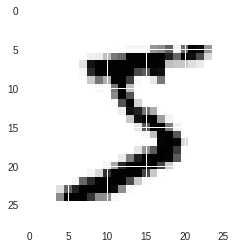

In [13]:
dset = data('MNIST')
sample_size = dset.train_data.size(0)
print(sample_size)

In [0]:
batch_size = 256
dataloader = torch.utils.data.DataLoader(dset, batch_size=batch_size, shuffle=True)


### Discriminator

In [0]:
class Discriminator(nn.Module):
  """
  Three FCN-layer Discriminative Network
  """
  def __init__(self):
    super().__init__()
    features = 28*28
    out = 1
    
    self.output_ = nn.Sequential(nn.Linear(256, out), nn.Sigmoid())
    self.network = nn.Sequential(self.hidden(features, 1024), self.hidden(1024,512),self.hidden(512,256), self.output_)
    
    
  def hidden(self, in_, out_): return nn.Sequential(nn.Linear(in_, out_), nn.LeakyReLU(0.2), nn.Dropout(0.3)) 
  
  def forward(self, x): return self.network(x)

In [16]:
print(Discriminator())

Discriminator(
  (output_): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): Sigmoid()
  )
  (network): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Dropout(p=0.3)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Dropout(p=0.3)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Dropout(p=0.3)
    )
    (3): Sequential(
      (0): Linear(in_features=256, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
)


### Generator

In [0]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    in_ = 100
    out_ = 28*28
    
    self.output_ = nn.Sequential(nn.Linear(1024, out_), nn.Tanh())
    self.network = nn.Sequential(self.hidden(in_, 256), self.hidden(256,512), self.hidden(512,1024),self.output_)
    
  def hidden(self, in_, out_):return nn.Sequential(nn.Linear(in_,out_), nn.LeakyReLU(0.2))
  
  def forward(self, x): return self.network(x)

In [18]:
print(Generator())

Generator(
  (output_): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias=True)
    (1): Tanh()
  )
  (network): Sequential(
    (0): Sequential(
      (0): Linear(in_features=100, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Linear(in_features=1024, out_features=784, bias=True)
      (1): Tanh()
    )
  )
)


In [0]:
discriminator = Discriminator()
generator = Generator()

if torch.cuda.is_available():
  discriminator.cuda()
  generator.cuda()

### Optimization

In [0]:
d = optim.Adam(discriminator.parameters(), lr=0.0002)
g = optim.Adam(generator.parameters(), lr=0.0002)

loss = nn.BCELoss()

d_steps = 1
num_epochs = 200

### Training

In [0]:
# Preparing Targets:
def real_data_targets(size):
  data = Variable(torch.ones(size,1))
  if torch.cuda.is_available():return data.cuda()
  return data

def fake_data_targets(size):
  data = Variable(torch.zeros(size, 1))
  if torch.cuda.is_available(): return data.cuda()
  return data


In [0]:
def train_discriminator(optimizer, real_data, fake_data):
  optimizer.zero_grad()
  
  prediction_real = discriminator(real_data)
  error_real = loss(prediction_real, real_data_targets(real_data.size(0)))
  error_real.backward(retain_graph=True)
#   print(prediction_real)
  
  prediction_fake = discriminator(fake_data)
  error_fake = loss(prediction_fake,fake_data_targets(real_data.size(0)))
  error_fake.backward(retain_graph=True)
  
  optimizer.step()
  
  return error_real+error_fake, prediction_real, prediction_fake


def train_generator(optimizer, fake_data):
  optimizer.zero_grad()
  
  prediction = discriminator(fake_data)
  error = loss(prediction, real_data_targets(prediction.size(0)))
  error.backward()
  
  optimizer.step()
  return error


In [0]:
## Generating Display Samples
num_samples = 16
test_noise = noise(num_samples)


In [0]:
epochs = 200
for epoch in range(epochs):
  for i, (batch,_) in enumerate(dataloader):
    
    # Train the Discriminator
    
    real_data = Variable(images_to_vectors(batch))
    real_data = real_data.cuda() if torch.cuda.is_available() else real_data
    
    fake_data = generator(noise(real_data.size(0))).detach()
    d_error, d_pred_real, d_pred_fake = train_discriminator(d, real_data, fake_data)
    
    # Train the Generator
    
    fake_data = generator(noise(real_data.size(0)))
    g_error = train_generator(g, fake_data)
    
    
    # logging
    steps = epoch*((sample_size//batch_size)+1 if sample_size%batch_size == 0 else sample_size//batch_size)+i
    print(g_error.data, d_error.data, steps)
    
    log(g_error.data.cpu().numpy(), d_error.data.cpu().numpy(), steps)
    
    if i%100 == 1:

      test_images = vectors_to_images(generator(test_noise)).data.cpu()
      grid = load(test_images, epoch, i)
      summary_writer.add_image('Zilla',grid, steps)
      
    

tensor(0.6970, device='cuda:0') tensor(1.4117, device='cuda:0') 0
tensor(0.6920, device='cuda:0') tensor(1.2784, device='cuda:0') 1
tensor(0.6855, device='cuda:0') tensor(1.1586, device='cuda:0') 2
tensor(0.6748, device='cuda:0') tensor(1.0459, device='cuda:0') 3
tensor(0.6587, device='cuda:0') tensor(0.9516, device='cuda:0') 4
tensor(0.6313, device='cuda:0') tensor(0.8835, device='cuda:0') 5
tensor(0.5950, device='cuda:0') tensor(0.8632, device='cuda:0') 6
tensor(0.5524, device='cuda:0') tensor(0.8873, device='cuda:0') 7
tensor(0.5023, device='cuda:0') tensor(0.9415, device='cuda:0') 8
tensor(0.4598, device='cuda:0') tensor(1.0253, device='cuda:0') 9
tensor(0.4199, device='cuda:0') tensor(1.1299, device='cuda:0') 10
tensor(0.3988, device='cuda:0') tensor(1.2059, device='cuda:0') 11
tensor(0.3784, device='cuda:0') tensor(1.2949, device='cuda:0') 12
tensor(0.3828, device='cuda:0') tensor(1.3370, device='cuda:0') 13
tensor(0.3989, device='cuda:0') tensor(1.3261, device='cuda:0') 14
tenso

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


tensor(0.9456, device='cuda:0') tensor(1.0376, device='cuda:0') 1606
tensor(1.0215, device='cuda:0') tensor(1.0491, device='cuda:0') 1607
tensor(1.0031, device='cuda:0') tensor(1.0415, device='cuda:0') 1608
tensor(1.0381, device='cuda:0') tensor(1.0268, device='cuda:0') 1609
tensor(1.0163, device='cuda:0') tensor(1.0377, device='cuda:0') 1610
tensor(1.0634, device='cuda:0') tensor(1.0257, device='cuda:0') 1611
tensor(1.0608, device='cuda:0') tensor(1.0569, device='cuda:0') 1612
tensor(1.0552, device='cuda:0') tensor(1.0128, device='cuda:0') 1613
tensor(1.0169, device='cuda:0') tensor(1.1140, device='cuda:0') 1614
tensor(0.9679, device='cuda:0') tensor(1.0920, device='cuda:0') 1615
tensor(0.9146, device='cuda:0') tensor(1.0969, device='cuda:0') 1616
tensor(0.9362, device='cuda:0') tensor(1.1388, device='cuda:0') 1617
tensor(0.9783, device='cuda:0') tensor(1.0893, device='cuda:0') 1618
tensor(0.9993, device='cuda:0') tensor(1.1157, device='cuda:0') 1619
tensor(0.9981, device='cuda:0') te